In [1]:
from utils.mnist import MNIST, MNIST_NORMALIZATION
from utils.emnist import EMNIST
from utils.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from utils.score import plot
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,mode = 'all',transform=tf)
test_id = MNIST('./dataset/', download=True,mode = 'all',transform=tf,train=False)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = simple_cnn(y_dim = 10,h_dims=[128,32]).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


### Training

In [4]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.1966, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1308, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0340, device='cuda:0', grad_fn=<NllLossBackward>)


### Test Accuracy

In [5]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9845


### Uncertainty

In [6]:
maha = maha_distance('RMD',5)

In [7]:
ftrain = []
with torch.no_grad():
    for image,label in train_loader:
        feature = model.net(image.to('cuda'))
        ftrain += feature.cpu().numpy().tolist()
maha.model_feature(ftrain)

(32, 32)


In [8]:
maha.type = 'RMD'
scale = 100
ftest= []
with torch.no_grad():
    for image,label in test_id_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
id_score = maha.score(ftest)
print(id_score.shape)
print(np.mean(id_score))

ftest= []
with torch.no_grad():
    for image,label in test_near_ood_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
near_ood_score = maha.score(ftest)
print(np.mean(near_ood_score))


ftest= []
with torch.no_grad():
    for image,label in test_far_ood_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
far_ood_score = maha.score(ftest)
print(np.mean(far_ood_score))


RMD
(10000,)
-1577.0318256966364
RMD
-548.690847740732
RMD
-212.26857375879283


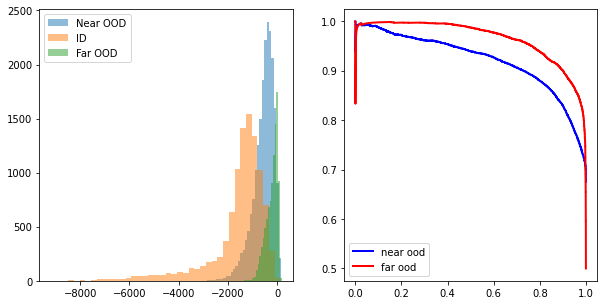

Near AUROC:0.8626206586538462, Far AUROC: 0.9683280400000002


In [9]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='relative-maha',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibaration

In [10]:
from sklearn.calibration import calibration_curve